In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import random

In [2]:
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.q_table = {format(i, '03b'): [0.0, 0.0, 0.0, 0.0] for i in range(8)}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        return int(np.argmax(self.q_table[state]))

    def update(self, state, action, reward, next_state):
        best_next = max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (reward + self.gamma * best_next - self.q_table[state][action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [12]:
def apply_depolarizing_noise(qc, qubits, error_prob):
    noise_model = NoiseModel()
    dep_error_1q = depolarizing_error(error_prob, 1)
    dep_error_2q = depolarizing_error(error_prob, 2)

    for q in qubits:
        noise_model.add_quantum_error(dep_error_1q, ["u1", "u2", "u3", "id"], [q])

    for q1, q2 in [(0, 1), (0, 2)]:
        noise_model.add_quantum_error(dep_error_2q, ["cx"], [q1, q2])

    return noise_model

In [3]:
def create_qec_circuit():
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(3, 'c')
    qc = QuantumCircuit(qr, cr)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    return qc, qr, cr

In [4]:
def add_decoding_and_measurements(qc, qr, cr):
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.measure([0, 1, 2], [0, 1, 2])
    return qc

In [5]:
def simulate_circuit(qc, noise_model=None, shots=1024):
    simulator = AerSimulator()
    result = simulator.run(qc, noise_model=noise_model, shots=shots).result()
    counts = result.get_counts()
    return counts

In [6]:
def simulate_qec_with_noise(noise_prob=0.01, shots=1024):
    qc, qr, cr = create_qec_circuit()
    noise_model = apply_depolarizing_noise(qc, [0, 1, 2], noise_prob)
    qc = add_decoding_and_measurements(qc, qr, cr)
    return simulate_circuit(qc, noise_model=noise_model, shots=shots)

In [7]:
def simulate_qec_without_noise(shots=1024):
    qc, qr, cr = create_qec_circuit()
    qc = add_decoding_and_measurements(qc, qr, cr)
    return simulate_circuit(qc, noise_model=None, shots=shots)

In [8]:
def apply_action(qc, action):
    if action == 1:
        qc.x(0)
    elif action == 2:
        qc.x(1)
    elif action == 3:
        qc.x(2)

In [9]:
def train_agent(agent, episodes=200, noise_prob=0.05):
    rewards = []
    for ep in range(episodes):
        total_reward = 0
        counts = simulate_qec_with_noise(noise_prob, shots=1)
        for syndrome, freq in counts.items():
            action = agent.act(syndrome)

            qc, qr, cr = create_qec_circuit()
            apply_action(qc, action)
            qc = add_decoding_and_measurements(qc, qr, cr)

            result = simulate_circuit(qc, noise_model=None, shots=1)
            reward = 1 if '000' in result else -1
            next_syndrome = list(result.keys())[0]

            agent.update(syndrome, action, reward, next_syndrome)
            total_reward += reward

        rewards.append(total_reward)
    return rewards

In [14]:
def evaluate_agent(agent, episodes=100, noise_prob=0.05):
    correct = 0
    for _ in range(episodes):
        counts = simulate_qec_with_noise(noise_prob, shots=1)
        for syndrome in counts:
            action = agent.act(syndrome)

            qc, qr, cr = create_qec_circuit()
            apply_action(qc, action)
            qc = add_decoding_and_measurements(qc, qr, cr)

            result = simulate_circuit(qc, noise_model=None, shots=1)
            if '000' in result:
                correct += 1
    accuracy = correct / episodes
    return accuracy

In [17]:
# Function to evaluate the baseline accuracy using random actions
def evaluate_baseline(episodes=100, noise_prob=0.05):
    correct = 0
    for _ in range(episodes):
        counts = simulate_qec_with_noise(noise_prob, shots=1)
        for syndrome in counts:
            # Random action selection (Baseline: random action)
            action = random.randint(0, 3)
            qc, qr, cr = create_qec_circuit()
            apply_action(qc, action)
            qc = add_decoding_and_measurements(qc, qr, cr)

            result = simulate_circuit(qc, noise_model=None, shots=1)
            if '000' in result:
                correct += 1
    return correct / episodes

In [16]:
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Q-Learning Reward Over Episodes")
    plt.grid(True)
    plt.show()

Baseline (random policy) Accuracy: 11.00%


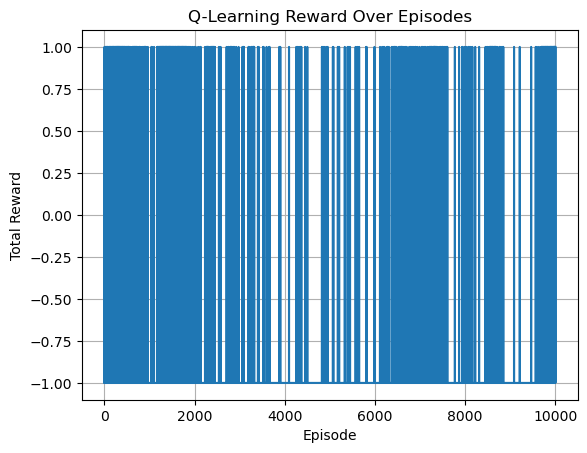

Trained RL Agent Accuracy: 40.00%


In [21]:
if __name__ == "__main__":
    # Evaluate baseline accuracy
    baseline_accuracy = evaluate_baseline(episodes=100, noise_prob=0.05)
    print(f"Baseline (random policy) Accuracy: {baseline_accuracy * 100:.2f}%")

    # Train the agent
    agent = QLearningAgent()
    rewards = train_agent(agent, episodes=10000, noise_prob=0.05)
    plot_rewards(rewards)

    # Evaluate the trained agent's performance
    accuracy = evaluate_agent(agent, episodes=100, noise_prob=0.05)
    print(f"Trained RL Agent Accuracy: {accuracy * 100:.2f}%")